# Predicting and understanding viewer engagement with educational videos
## About the prediction problem

One critical property of a video is engagement: how interesting or "engaging" it is for viewers, so that they decide to keep watching. Engagement is critical for learning, whether the instruction is coming from a video or any other source. There are many ways to define engagement with video, but one common approach is to estimate it by measuring how much of the video a user watches. If the video is not interesting and does not engage a viewer, they will typically abandon it quickly, e.g. only watch 5 or 10% of the total. 

A first step towards providing the best-matching educational content is to understand which features of educational material make it engaging for learners in general. This is where predictive modeling can be applied, via supervised machine learning. For this assignment, your task is to predict how engaging an educational video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)   # Do not change this value: required to be compatible with solutions generated by the autograder.

## Data Exploration

In [3]:
#peeking at the data
train_data = pd.read_csv('assets/train.csv')
train_data.shape

(9239, 10)

In [4]:
train_data.head()

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
0,1,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.0,True
1,2,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.0,False
2,3,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.0,False
3,4,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.0,False
4,5,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.0,False


In [5]:
#Check for nulls
train_data.isna().sum()

id                            0
title_word_count              0
document_entropy              0
freshness                     0
easiness                      0
fraction_stopword_presence    0
normalization_rate            0
speaker_speed                 0
silent_period_rate            0
engagement                    0
dtype: int64

In [6]:
train_data.dtypes

id                              int64
title_word_count                int64
document_entropy              float64
freshness                       int64
easiness                      float64
fraction_stopword_presence    float64
normalization_rate            float64
speaker_speed                 float64
silent_period_rate            float64
engagement                       bool
dtype: object

In [7]:
# checking correlation
correlation_matrix = train_data.corr()
correlation_matrix

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
id,1.000000,0.005341,-0.005961,0.015104,0.004669,0.002193,-0.001831,0.001404,0.002241,0.021167
title_word_count,0.005341,1.000000,0.007861,0.010169,-0.040933,-0.014945,0.039705,-0.076406,-0.007335,-0.030120
document_entropy,-0.005961,0.007861,1.000000,-0.140501,-0.376209,-0.057805,0.038679,0.264153,-0.352060,-0.263970
freshness,0.015104,0.010169,-0.140501,1.000000,-0.191736,-0.110930,0.131065,0.016699,-0.414012,0.225711
easiness,0.004669,-0.040933,-0.376209,-0.191736,1.000000,0.577259,-0.604340,-0.112795,0.423378,-0.150089
fraction_stopword_presence,0.002193,-0.014945,-0.057805,-0.110930,0.577259,1.000000,-0.291580,-0.026725,0.180411,-0.136340
normalization_rate,-0.001831,0.039705,0.038679,0.131065,-0.604340,-0.291580,1.000000,-0.002837,-0.134752,0.075936
speaker_speed,0.001404,-0.076406,0.264153,0.016699,-0.112795,-0.026725,-0.002837,1.000000,-0.111824,-0.010440
silent_period_rate,0.002241,-0.007335,-0.352060,-0.414012,0.423378,0.180411,-0.134752,-0.111824,1.000000,-0.130908
engagement,0.021167,-0.030120,-0.263970,0.225711,-0.150089,-0.136340,0.075936,-0.010440,-0.130908,1.000000


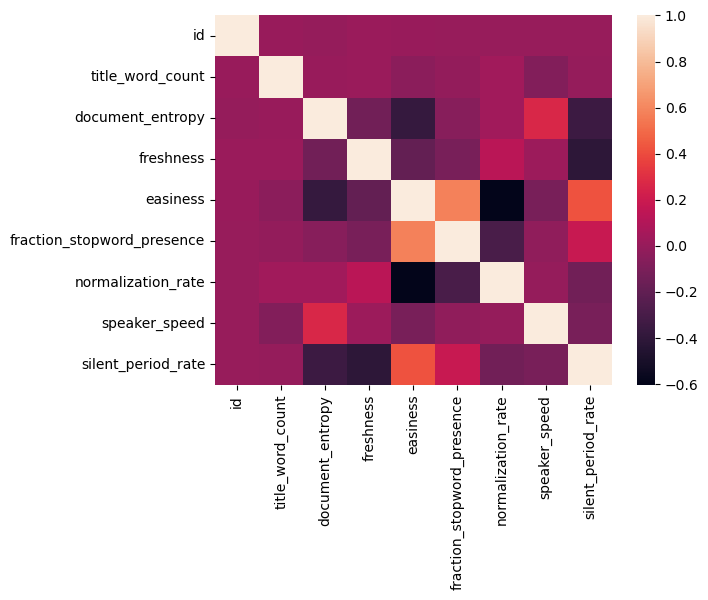

In [8]:
#Visualizing correlation using heatmap

import seaborn as sns
%matplotlib inline

# calculate the correlation matrix on the numeric columns
corr = train_data.select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr);

In [9]:
class_dist = train_data['engagement'].value_counts()
class_dist

False    8342
True      897
Name: engagement, dtype: int64

In [10]:
#Checking class distribution
class_prop = train_data['engagement'].value_counts(normalize=True)
class_prop

False    0.902912
True     0.097088
Name: engagement, dtype: float64

In [11]:
#view of stats
train_data.describe()

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate
count,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000
mean,4620.000000,7.701050,7.792685,14808.587509,84.756029,0.612214,0.021354,2.413320,0.146606
std,2667.213902,3.785066,0.697710,1208.953646,8.303489,0.051872,0.009545,1.588296,0.172030
min,1.000000,1.000000,0.000000,10830.000000,28.210966,0.000000,0.000000,0.000302,0.000000
25%,2310.500000,5.000000,7.594235,14070.000000,80.415060,0.589632,0.014974,1.976727,0.000000
50%,4620.000000,7.000000,7.875103,14750.000000,84.482122,0.613127,0.019843,2.267133,0.104915
75%,6929.500000,10.000000,8.164166,15600.000000,88.388711,0.634585,0.026288,2.539207,0.250927
max,9239.000000,33.000000,9.278573,17430.000000,122.032000,1.000000,0.101990,50.850000,1.168239


### Box plots to check for outliers in data

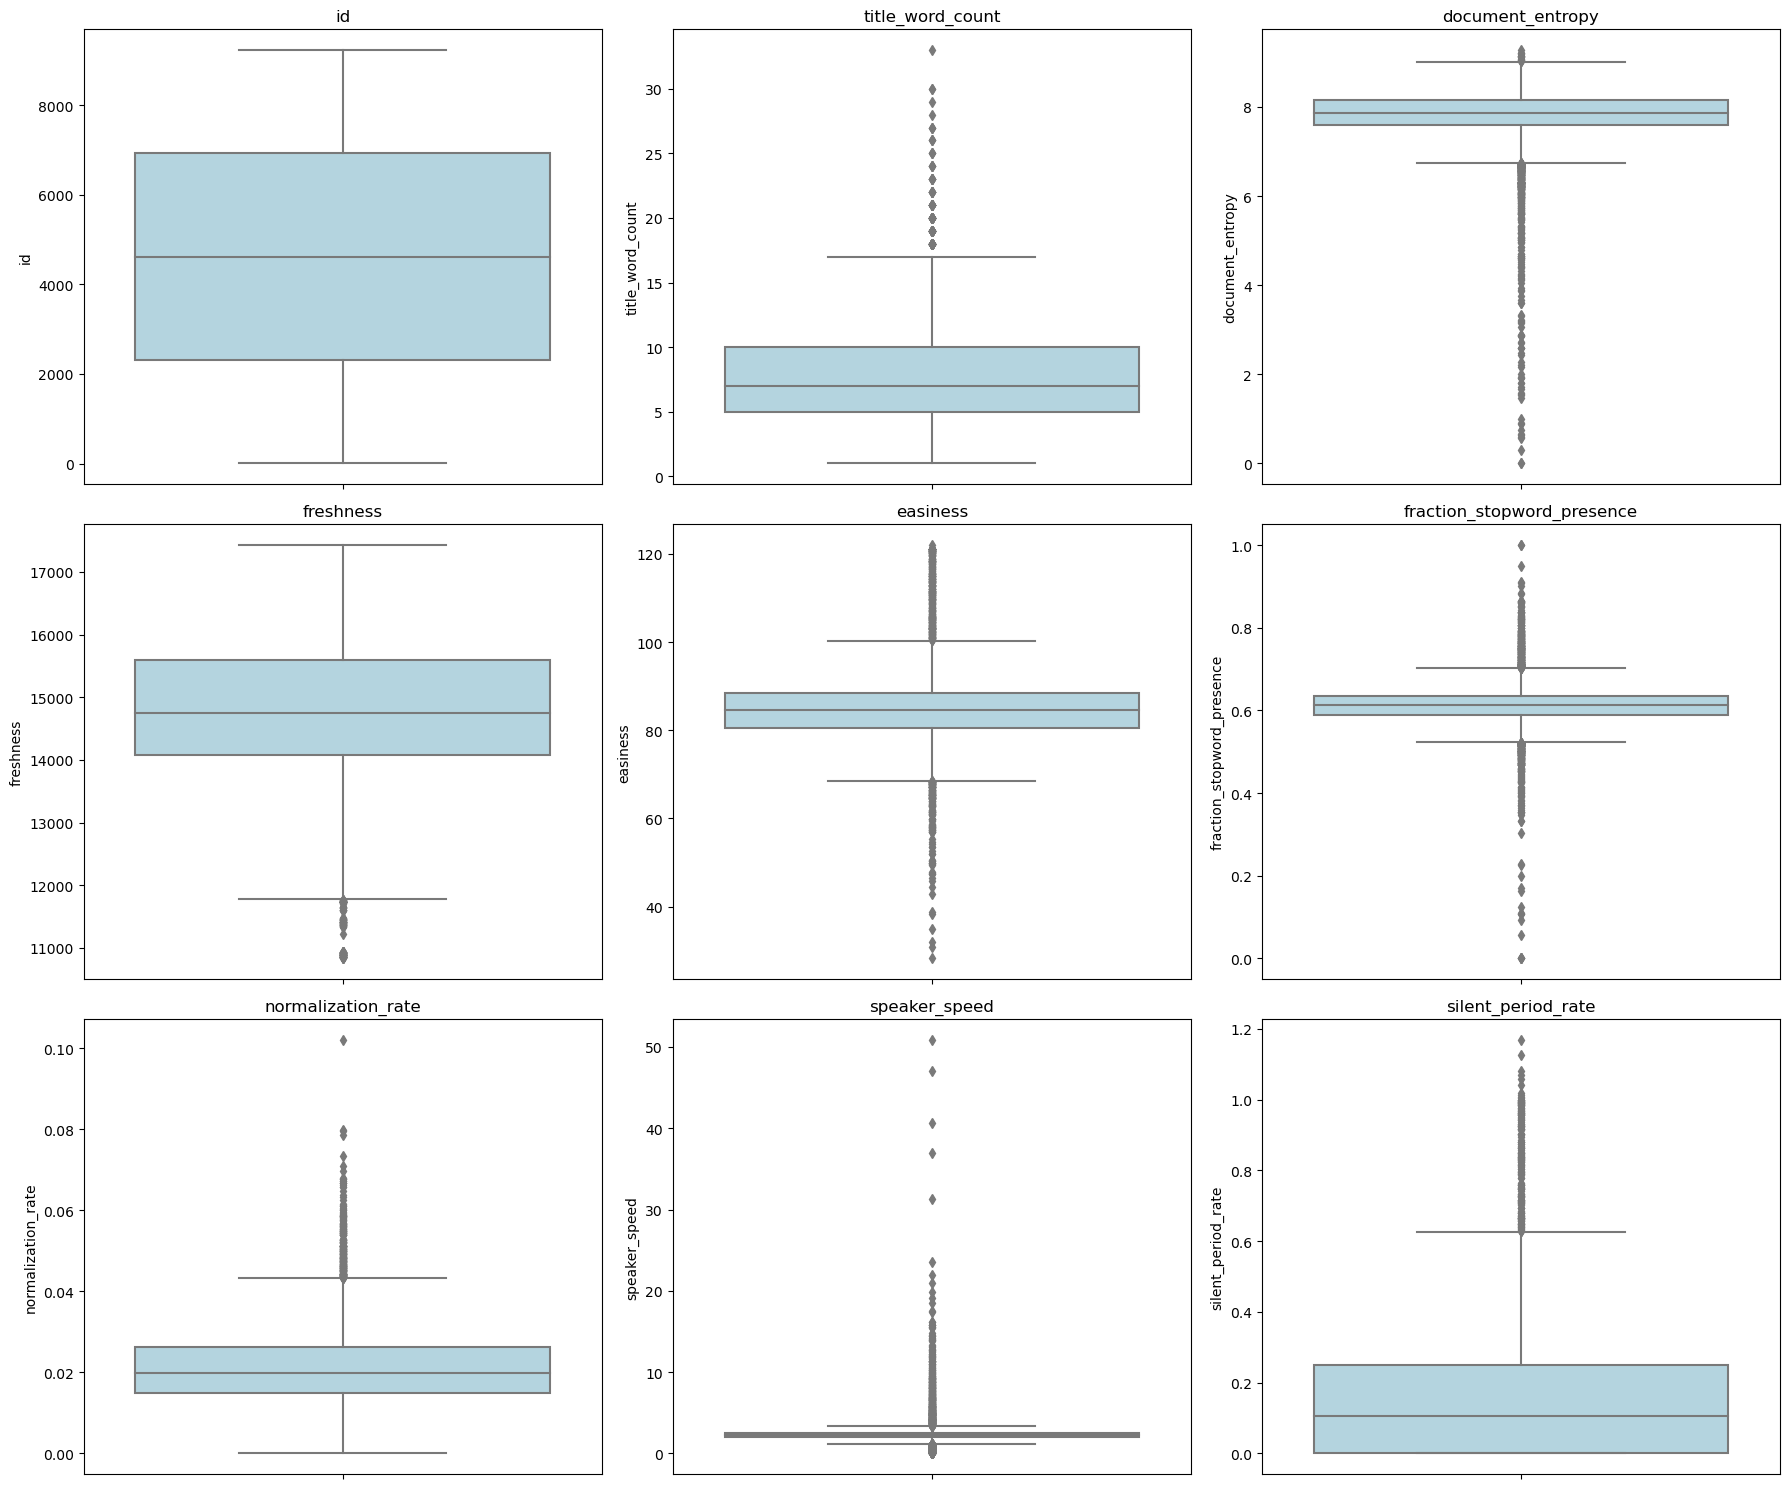

In [12]:
# Define feature names in full form for titles and axis
num_features = len(train_data.columns[:-1])
cols = 3
rows = (num_features + cols - 1) // cols  # Calculates needed rows

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()  

for i, feature in enumerate(train_data.columns[:-1]):
    sns.boxplot(y=train_data[feature], ax=axes[i], color="lightblue")
    axes[i].set_title(feature)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()


### Plotting histograms to get a view of the distribution across features

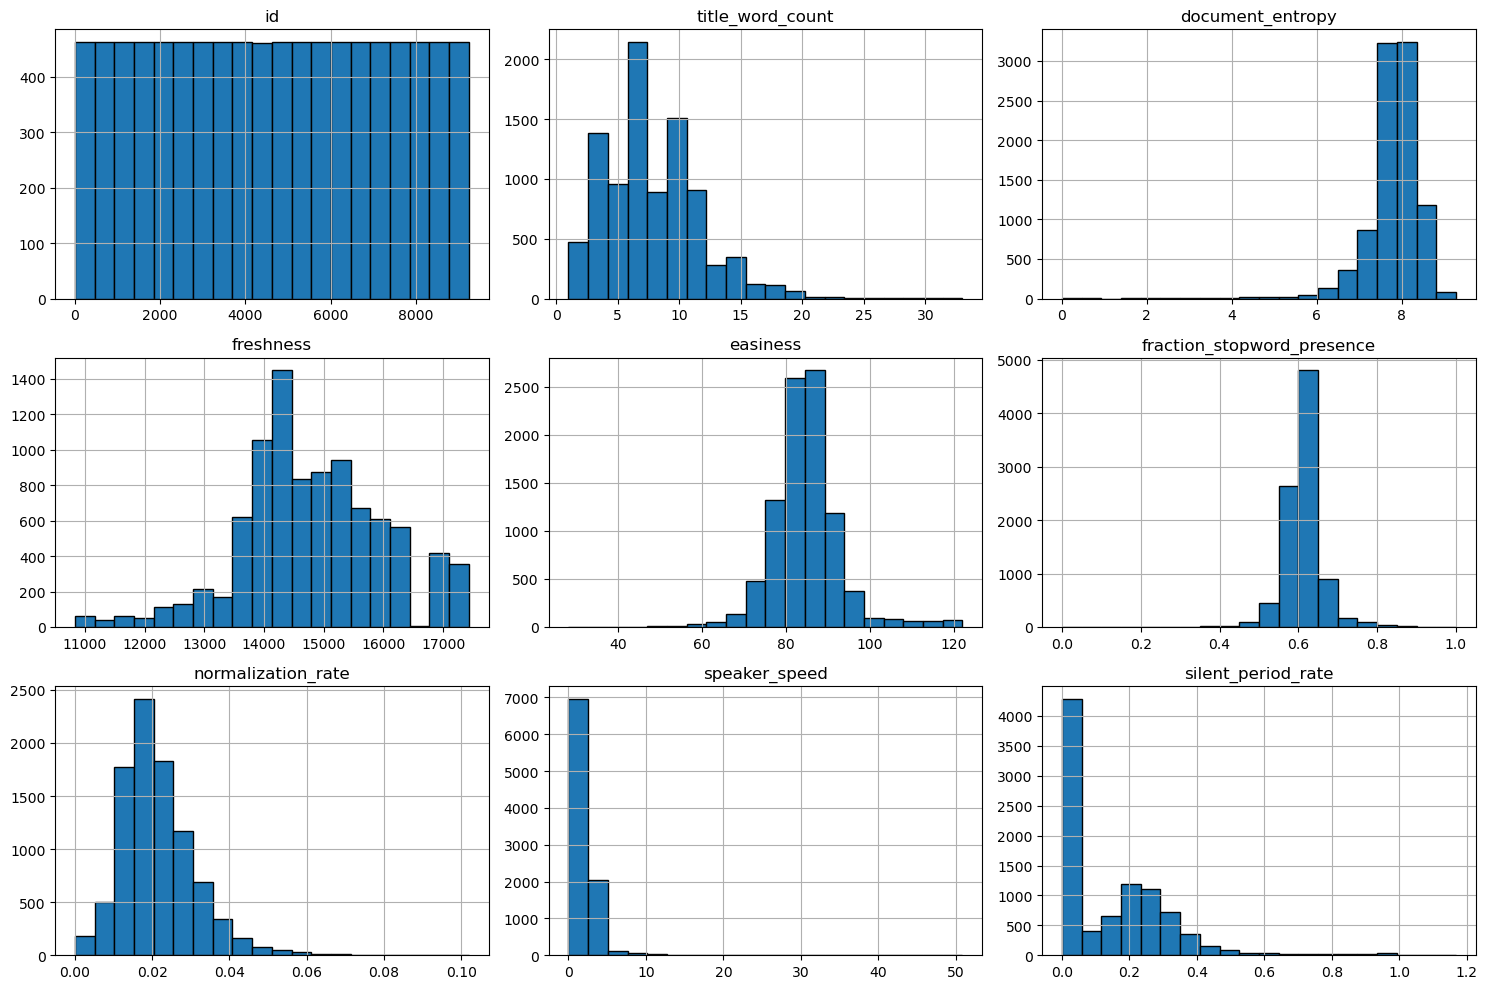

In [13]:
train_data.hist(bins=20, figsize=(15, 10), layout=(3, 3), edgecolor='black')

plt.tight_layout()
plt.show()

In [14]:
#check for dupes
train_data.duplicated().sum()

0

In [15]:
## Keep only columns to use as features in the model
feature_cols = ["title_word_count","document_entropy", "freshness", "easiness", "fraction_stopword_presence", "speaker_speed", "silent_period_rate"]          

In [16]:
#defining X and target variable
X = train_data[feature_cols]
y = train_data['engagement'].astype(int)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

### Using Dummy Classifier

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_majority_predicted = dummy_majority.predict(X_val)
y_majority_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
confusion = confusion_matrix(y_val, y_majority_predicted)

print(f"Most frequent class (dummy classifier):\n {confusion}")

Most frequent class (dummy classifier):
 [[1669    0]
 [ 179    0]]


## Using logistic regression classifier

### Confusion Matrix

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix 

logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_val)

confusion = confusion_matrix(y_val, y_pred)

print(f"Logistic Regression Classifier (default settings):\n {confusion}")


Logistic Regression Classifier (default settings):
 [[1651   18]
 [ 153   26]]


### Get scoring metrics for logistic regression

In [21]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_val)
y_probs = logreg.predict_proba(X_val)[:,1]

accuracy = accuracy_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_probs)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Recall:   {recall:.4f}")
print(f"Logistic Regression AUC Score: {auc:.4f}")


Logistic Regression Accuracy: 0.9075
Logistic Regression Recall:   0.1453
Logistic Regression AUC Score: 0.8204


### Plot ROC Curve for logistic regression

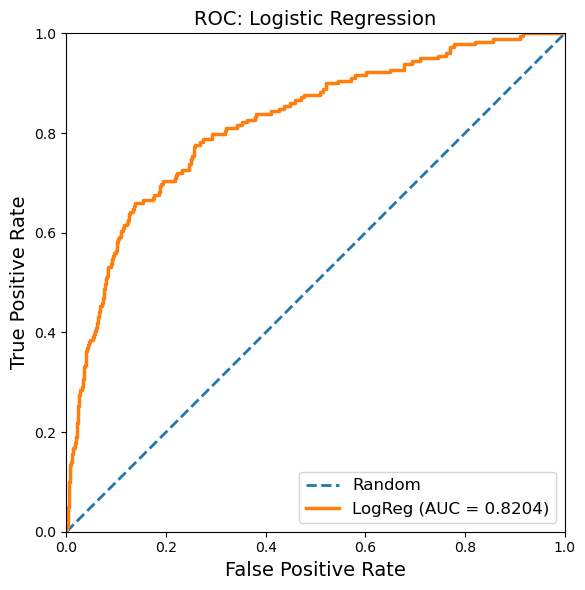

In [22]:
from sklearn.metrics import roc_curve, auc

# Fitting model
logreg.fit(X_train, y_train)

#predicting
y_lr_pred = logreg.predict_proba(X_val)[:,1]

fpr, tpr, _ = roc_curve(y_val, y_lr_pred)
roc_auc_lr = auc(fpr, tpr)

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot([0, 1], [0, 1], linestyle="--", linewidth=2, label="Random")
ax.plot(fpr, tpr, linewidth=2.5, label=f"LogReg (AUC = {roc_auc_lr:.4f})")

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect("equal", adjustable="box")

ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.set_title("ROC: Logistic Regression", fontsize=14)

ax.legend(loc="lower right", fontsize=12)
fig.tight_layout()
plt.show()


## Using XGBoost Classifier

### Scoring metrics

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, objective="binary:logistic",
                      eval_metric="logloss", random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_probs = model.predict_proba(X_val)[:, 1] # Probability of class 1

accuracy = accuracy_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_probs)

print(f"The model's accuracy score using XGBoost is: {accuracy:.4f}")
print(f"The model's recall score (true positive rate) using XGBoost is:   {recall:.4f}")
print(f"The model's AUC score using XGBoost is: {auc:.4f}")


The model's accuracy score using XGBoost is: 0.9297
The model's recall score (true positive rate) using XGBoost is:   0.3966
The model's AUC score using XGBoost is: 0.8922


### Plotting the ROC Curve for XGBoost

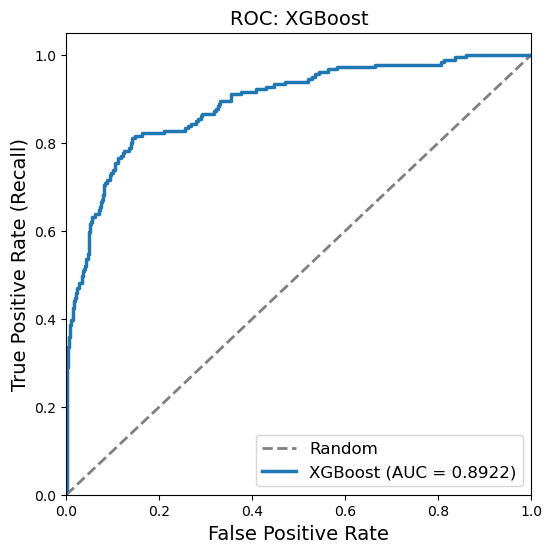

In [24]:
from sklearn.metrics import roc_curve, auc

fpr_xg, tpr_xg, thresholds = roc_curve(y_val, y_probs)
roc_auc_xg = auc(fpr_xg, tpr_xg)

# Plotting 
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=2, label="Random", color='gray')
ax.plot(fpr_xg, tpr_xg, linewidth=2.5, label=f"XGBoost (AUC = {roc_auc_xg:.4f})")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate (Recall)", fontsize=14)
ax.set_title("ROC: XGBoost", fontsize=14)
ax.legend(loc="lower right", fontsize=12)
plt.show()


### Using Random Forest Classifier 

The model's accuracy score using Random Forest classifier is 0.9286
The model's recall score using Random Forest classifier is 0.3631
The model's AUC score using Random Forest classifier is 0.8760


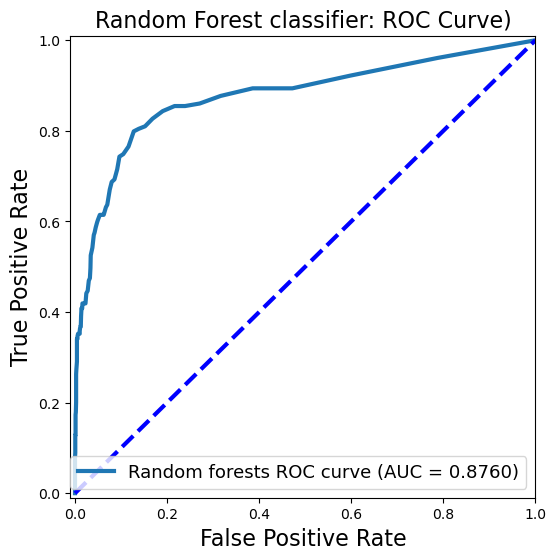

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

clf = RandomForestClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_val)
y_probabilities = clf.predict_proba(X_val)[:,1]

fpr_rf, tpr_rf, _ = roc_curve(y_val, y_probabilities)
roc_auc_rf = auc(fpr_rf, tpr_rf)

accuracy = accuracy_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
auc_val = roc_auc_score(y_val, y_probabilities)

print(f"The model's accuracy score using Random Forest classifier is {accuracy:.4f}")
print(f"The model's recall score using Random Forest classifier is {recall:.4f}")
print(f"The model's AUC score using Random Forest classifier is {auc_val:.4f}")

plt.figure(figsize=(6,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=3, label='Random forests ROC curve (AUC = {:0.4f})'.format(roc_auc_rf))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Random Forest classifier: ROC Curve)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='blue', lw=3, linestyle='--')
plt.show()


### Using SuccessiveHalving for hyper parameter tuning

In [ ]:

from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV
from xgboost import XGBClassifier

clf = XGBClassifier(
    objective="binary:logistic", 
    tree_method="hist",      
    eval_metric="auc"
)

param_dist = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 9, 15],  
    'min_child_weight': [1, 5]
}

search = HalvingRandomSearchCV(
    clf, 
    param_dist, 
    resource='n_samples',    
    max_resources='auto',    
    factor=3, 
    scoring='roc_auc', 
    cv=3,                    
    random_state=0,
    n_jobs=-1
    )


search.fit(X_train, y_train)
print(f"Best Params: {search.best_params_}")


### Re-run of XGBoost Classifier - Fine Tuned version

In [32]:
# Combining back the training and validation data 

X_train_full = pd.concat([X_train, X_val], ignore_index=True)
y_train_full = pd.concat([y_train, y_val], ignore_index=True)


In [33]:
from xgboost import XGBClassifier

# Using best parameters from the tuning
best_params = {
    'scale_pos_weight': 15, 
    'min_child_weight': 5, 
    'max_depth': 6, 
    'learning_rate': 0.01,
    'objective': "binary:logistic", 
    'eval_metric': "auc",           
    'random_state': 0               
}

final_tuned_model = XGBClassifier(**best_params)

final_tuned_model.fit(X_train_full, y_train_full)

# Final evaluation
y_probs = final_model.predict_proba(X_val)[:, 1]

y_pred = final_tuned_model.predict(X_val)
y_probs = final_tuned_model.predict_proba(X_val)[:, 1] 

accuracy = accuracy_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_probs)

print(f"The final model's accuracy score using XGBoost is: {accuracy:.4f}")
print(f"The final model's recall score (true positive rate) using XGBoost is: {recall:.4f}")
print(f"The final model's AUC score using XGBoost is: {auc:.4f}")


The final model's accuracy score using XGBoost is: 0.8512
The final model's recall score (true positive rate) using XGBoost is: 0.8603
The final model's AUC score using XGBoost is: 0.9449


### Final testing on holdout set

In [30]:
test_data = pd.read_csv('assets/test.csv')
test_data.shape

(2309, 9)

In [31]:
test_data.head()

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate
0,9240,6,8.548351,14140,89.827395,0.640810,0.017945,2.262723,0.000000
1,9241,8,7.730110,14600,82.446667,0.606738,0.027708,2.690351,0.000000
2,9242,3,8.200887,16980,88.821542,0.621089,0.009857,3.116071,0.000000
3,9243,5,6.377299,16260,86.874660,0.600000,0.004348,2.837500,0.017994
4,9244,18,7.756530,14030,88.872277,0.616105,0.033240,1.354839,0.000000


In [ ]:
## Final (** Prod Ready**) Model

def engagement_model():
    
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split 
    import pandas as pd
    import numpy as np

    train_df = pd.read_csv('assets/train.csv')
    test_df = pd.read_csv('assets/test.csv')

    feature_cols = ["title_word_count", "document_entropy", "freshness", "easiness", "fraction_stopword_presence", "speaker_speed", "silent_period_rate"]
    target_col = "engagement"
    id_col = "id"

    X_train, X_val, y_train, y_val = train_test_split(
        train_df[feature_cols], 
        train_df[target_col].astype(int), 
        test_size=0.2, 
        random_state=0
    )

    best_params = {
        "scale_pos_weight": 15,
        "min_child_weight": 5,
        "max_depth": 6,
        "learning_rate": 0.01,
        "objective": "binary:logistic",
        "random_state": 0
    }

    model = XGBClassifier(**best_params, eval_metric='auc')
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    results = model.evals_result()
    final_auc = results['validation_0']['auc'][-1]
    
    print(f"The model's validation set AUC is: {final_auc}")

    y_probs = model.predict_proba(test_df[feature_cols])[:, 1]

    engagement_probs = pd.Series(
        y_probs.astype(np.float32),
        index=test_df[id_col],
        name="engagement"
    )
    rec.index.name = "id"
    
    return engagement_probs
 
    

